# Examples

To use `pyinverse` in a project:

## Initialize the package

In [1]:
%load_ext autoreload
%autoreload 2

In [118]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
# Use the seaborn notebook style
plt.style.use('seaborn-v0_8-notebook')
import matplotlib as mpl

from pyinverse.forward_model import Linear
from pyinverse.loss import LeastSquares, Thikonov, Bayesian
from pyinverse.solver import LSTSQ


## Falling stone

Simple example of a linear regression to infer the acceleration of a stone in the gravity field of the earth.

$$
s = \frac{1}{2} a t^2
$$

$$
y = K x
$$

$$
\begin{aligned}
y &= s \\
K &= \frac{1}{2} t^2 \\
x &= a
\end{aligned}
$$

In [119]:
# Measurements
measurements = dict()
measurements["height"] = np.array([1, 2, 3, 4, 5]) # m
measurements["time"] = np.array([0.46, 0.62, 0.78, 0.90, 1.01]) # s

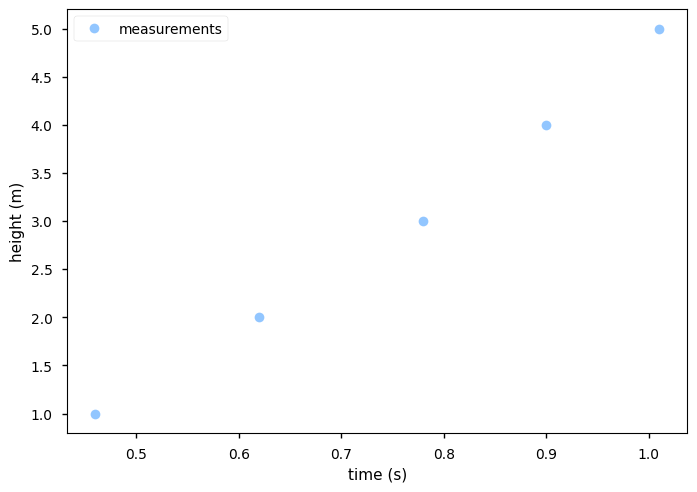

In [120]:
plt.plot(measurements["time"], measurements["height"], "o", label="measurements")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("height (m)")
plt.show()

In [121]:
# Formulate as inverse problem
y = measurements["height"]
K = 0.5 * measurements["time"][:, None] ** 2

In [122]:
# Create forward model
forward_model = Linear(K)
# Loss function
loss = LeastSquares(y, K)
# Solver
solver = LSTSQ(loss)

In [123]:
a = solver()[0]

In [124]:
# Create a prediction for the measurements
y_pred = forward_model(a)

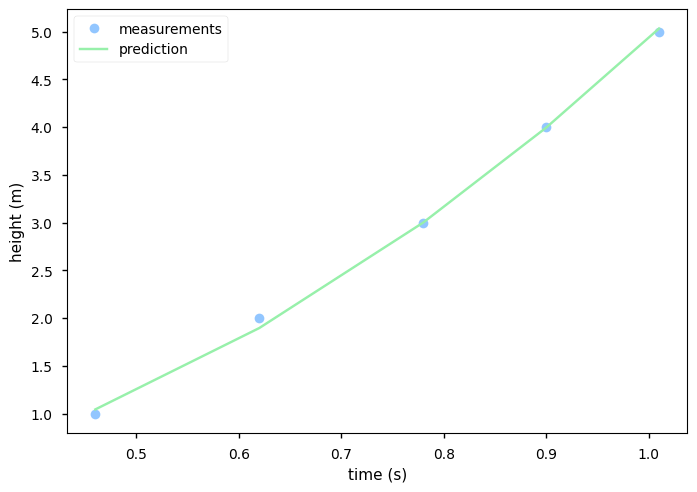

In [125]:
plt.plot(measurements["time"], measurements["height"], "o", label="measurements")
plt.plot(measurements["time"], y_pred, "-x", label="prediction")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("height (m)")
plt.show()

## Diffusion from a point source 

Taken from tutorial 6 of the "Inverse Problems of the Atmsphere" course at Heidelberg University, 2021 by Prof. Dr. André Butz, Exercise by Sanam Vardag.

Simple example of a linear regression to infer the emissions of a point source in a 3D domain. The point source is located at $(x_0, y_0, z_0)$ with a constant emission rate $E[kg/s]$.

Gaussian diffusion:
$$
    c(x, y, z) = \frac{E}{2\pi\,u_0\,\sigma_y(x)\,\sigma_z(x)} 
    \exp \left( - \frac{(y - y_0)^2}{2 \sigma_y(x)^2} \right) 
    \exp \left( - \frac{(z - z_0)^2}{2 \sigma_z(x)^2} \right)
$$
for $x \geq x_0$

with
$$
    \sigma_{y, z}(x) = \sqrt{2 K_{y, z} t} = \sqrt{2 K_{y, z} \frac{x - x_0}{u_0}}
$$

In [126]:
def exponential(x, x0, sigma):
    """
    Gaussian function

    Parameters
    ----------
    x : array_like
        x values
    x0 : scalar
        x offset
    sigma : scalar
        standard deviation

    Returns
    -------
    y : ndarray
        Gaussian function values
    """
    return np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def compute_sigma(x, x0, u0, K):
    """
    Compute sigma

    Parameters
    ----------
    x : array_like
        x values
    x0 : scalar
        x offset
    u0 : scalar
        initial velocity
    K : scalar
        spring constant

    Returns
    -------
    sigma : ndarray
        standard deviation
    """
    return np.sqrt(2 * K * (x - x0) / u0)

In [127]:
def compute_diffusion(x, y, z, x0, y0, z0, u0, K_y, K_z):
    """
    Compute the concentration at position (x, y, z) using the
    given parameters.

    Parameters
    ----------
    x : float
        The x position to compute the concentration for
    y : float
        The y position to compute the concentration for
    z : float
        The z position to compute the concentration for
    x0 : float
        The x position of the source
    y0 : float
        The y position of the source
    z0 : float
        The z position of the source
    u0 : float
        The wind speed at the source
    K_y : float
        The diffusion coefficient in the y direction
    K_z : float
        The diffusion coefficient in the z direction

    Returns
    -------
    float
        The concentration at position (x, y, z) in kg/m^3

    """
    if x > x0:
        sigma_y = compute_sigma(x, x0, u0, K_y)
        sigma_z = compute_sigma(x, x0, u0, K_z)
        frac = 1 / (2 * np.pi * u0 *sigma_y * sigma_z)
        exp_y = exponential(y, y0, sigma_y)
        exp_z = exponential(z, z0, sigma_z)
        return frac * exp_y * exp_z
    else:
        return 0

def compute_con(x, y, z, x0, y0, z0, E, u0, K_y, K_z):
    """
    Compute the concentration at position (x, y, z) using the
    given parameters.

    Parameters
    ----------
    x : float
        The x position to compute the concentration for
    y : float
        The y position to compute the concentration for
    z : float
        The z position to compute the concentration for
    x0 : float
        The x position of the source
    y0 : float
        The y position of the source
    z0 : float
        The z position of the source
    E : float
        The emission rate of the source
    u0 : float
        The wind speed at the source
    K_y : float
        The diffusion coefficient in the y direction
    K_z : float
        The diffusion coefficient in the z direction

    Returns
    -------
    float
        The concentration at position (x, y, z) in kg/m^3

    """
    return E * compute_diffusion(x, y, z, x0, y0, z0, u0, K_y, K_z)

In [128]:
# Wind velocity along the y-axis
u0 = 4 # m/s
# Horizontal dispersion coefficient
K_y = 40. # m^2/s
# Vertical dispersion coefficient
K_z = 10. # m^2/s

# Source locations
x0_list = [0., 50., 10.] # m
y0_list = [0., -10, -20.] # m
z0_list = [200., 200, 200] # m

# Emission rates
E_list = [10., 15., 20.] # kg/s


In [129]:
# Visualize the plume
z = 190
# Define the domain
x_bounds = (-100, 300)
y_bounds = (-200, 200)
n_steps = 100
# Create a mesh
x_mesh, y_mesh = np.meshgrid(
    np.linspace(*x_bounds, n_steps), np.linspace(*y_bounds, n_steps), indexing="ij"
)

con = np.zeros_like(x_mesh)
for i in range(x_mesh.shape[0]):
    for j in range(x_mesh.shape[1]):
        for x0, y0, z0, E in zip(x0_list, y0_list, z0_list, E_list):
            con[i, j] += compute_con(
                x_mesh[i, j], y_mesh[i, j], z, x0, y0, z0, E, u0, K_y, K_z
            )

# Transform into an xarray
con = xr.DataArray(con, coords=[("x", x_mesh[:, 0]), ("y", y_mesh[0, :])])
# Add units to the coordinates
con.x.attrs["units"] = "m"
con.y.attrs["units"] = "m"
# Add name and units to the data
con.name = "concentration"
con.attrs["units"] = "kg/m$^3$"


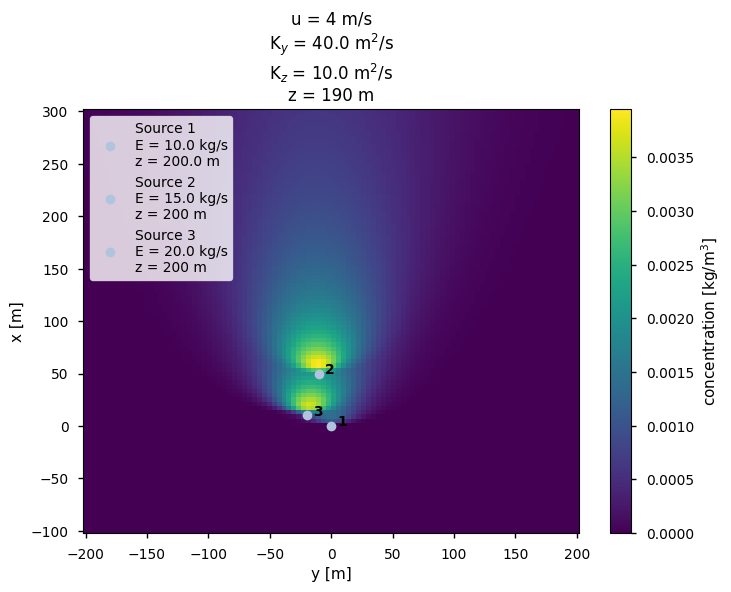

In [130]:
# Plot the plume
con.plot()
# Plot the sources position with information about the emission rate and height
for i, (x0, y0, z0, E) in enumerate(zip(x0_list, y0_list, z0_list, E_list)):
    # Plot the source and number it
    plt.plot(y0, x0, "o", color="lightsteelblue", label=f"Source {i + 1}\nE = {E} kg/s\nz = {z0} m")
    # Add the source number in bold text next to the source position
    plt.text(y0 + 5, x0, str(i + 1), fontweight="bold")
plt.legend(loc="upper left")
# Add a title with information about the wind speed, dispersion coefficients, and height
plt.title(f"u = {u0} m/s\nK$_y$ = {K_y} m$^2$/s\nK$_z$ = {K_z} m$^2$/s\nz = {z} m")
pass

In [131]:
# Now assume that a plane flies through the plumes at a height of 190 m parallel to the
# y-axis at x = 80 m. The plane measures the concentration at y = [-50, 50] m with a
# 10 m interval. 
y_meas = np.arange(-50, 60, 10)
x_meas = np.ones_like(y_meas) * 80

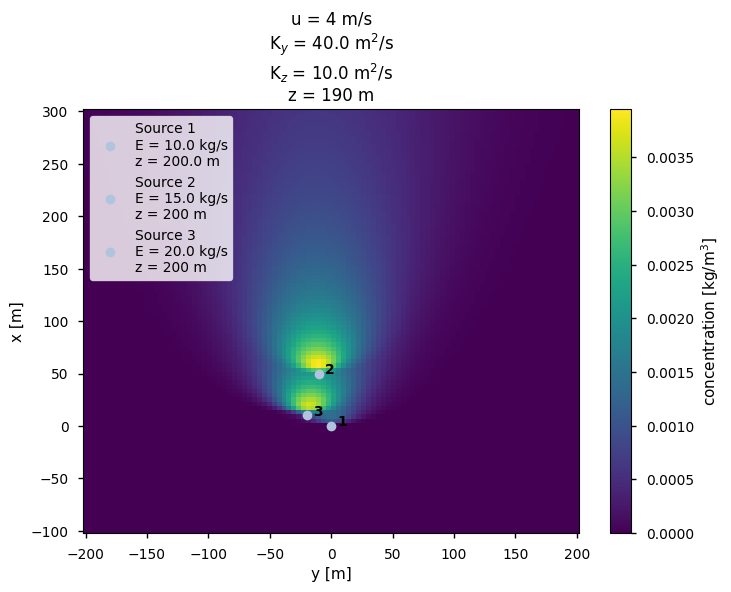

In [132]:
# Show the previous plot but with the measurement locations
con.plot()
plt.plot(y_meas, x_meas, "x", color="gold")
for i, (x0, y0, z0, E) in enumerate(zip(x0_list, y0_list, z0_list, E_list)):
    plt.plot(y0, x0, "o", color="lightsteelblue", label=f"Source {i + 1}\nE = {E} kg/s\nz = {z0} m")
    plt.text(y0 + 5, x0, str(i + 1), fontweight="bold")
plt.legend(loc="upper left")
plt.title(f"u = {u0} m/s\nK$_y$ = {K_y} m$^2$/s\nK$_z$ = {K_z} m$^2$/s\nz = {z} m")
pass

In [133]:
# Construct the transport matrix K for the measurements by using the compute_diffusion
# function. 
K = np.zeros((len(y_meas), len(x0_list)))
for i, (x0, y0, z0) in enumerate(zip(x0_list, y0_list, z0_list)):
    for j, (x, y) in enumerate(zip(x_meas, y_meas)):
        K[j, i] = compute_diffusion(x_meas[j], y, z, x0, y0, z0, u0, K_y, K_z)


In [134]:
# Compute the concentration at the measurement locations
con_meas = K @ E_list

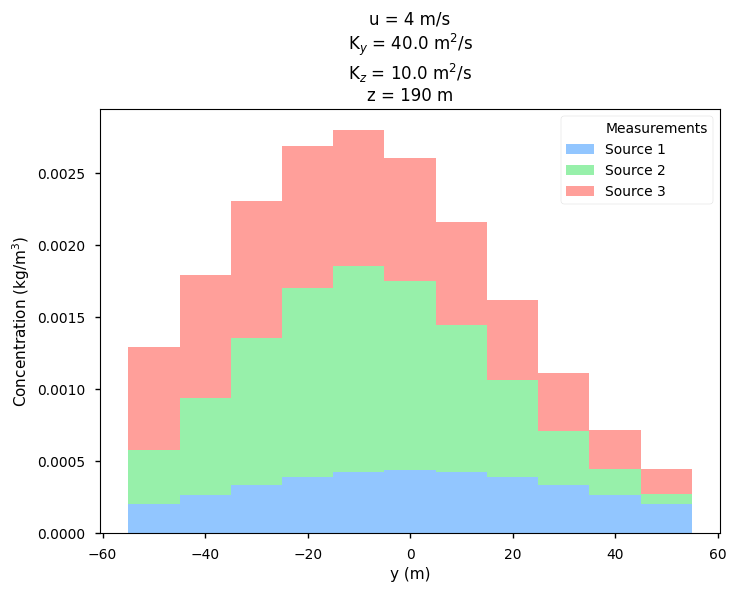

In [135]:
# Plot the concentration at the measurement locations
bottom = np.zeros_like(y_meas, dtype=float)
for i, E in enumerate(E_list):
    em_vec = np.zeros_like(E_list)
    em_vec[i] = E
    con_from_source = K @ em_vec
    plt.bar(y_meas, con_from_source, bottom=bottom, width=10, label=f"Source {i + 1}")
    bottom += con_from_source
plt.plot(y_meas, con_meas, "x", color="gold", label="Measurements")
plt.xlabel("y (m)")
plt.ylabel("Concentration (kg/m$^3$)")
plt.title(f"u = {u0} m/s\nK$_y$ = {K_y} m$^2$/s\nK$_z$ = {K_z} m$^2$/s\nz = {z} m")
plt.legend()
pass

In [136]:
# Solve the least squares problem
loss = LeastSquares(con_meas, K)
solver = LSTSQ(loss)  

In [137]:
x_est, res, rank, s = solver()

In [73]:
x_est

array([10., 15., 20.])

In [70]:
y_meas

array([-50, -40, -30, -20, -10,   0,  10,  20,  30,  40,  50])

In [ ]:
x_est

array([0.41935484, 1.32258065])

In [ ]:
x_prior = np.array([0, 1])
cov_prior = np.array([1,2])
loss = Bayesian(y=y, K=K, x_prior=x_prior, cov_prior=cov_prior)

TypeError: Bayesian.__init__() missing 1 required positional argument: 'cov_y'

In [ ]:
loss(x_est)

4.4687825182101975